In [3]:
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("arevel/chess-games")

csv_path = path + "/chess_games.csv"

df = pd.read_csv(csv_path)

print(df.shape)
print(df.columns)
print(df.head(3))


(6256184, 15)
Index(['Event', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime', 'WhiteElo',
       'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'ECO', 'Opening',
       'TimeControl', 'Termination', 'AN'],
      dtype='str')
                Event            White       Black Result     UTCDate  \
0          Classical           eisaaaa    HAMID449    1-0  2016.06.30   
1              Blitz            go4jas  Sergei1973    0-1  2016.06.30   
2   Blitz tournament   Evangelistaizac      kafune    1-0  2016.06.30   

    UTCTime  WhiteElo  BlackElo  WhiteRatingDiff  BlackRatingDiff  ECO  \
0  22:00:01      1901      1896             11.0            -11.0  D10   
1  22:00:01      1641      1627            -11.0             12.0  C20   
2  22:00:02      1647      1688             13.0            -13.0  B01   

                                         Opening TimeControl   Termination  \
0                                   Slav Defense       300+5  Time forfeit   
1                      K

In [4]:
df["Result"].value_counts(normalize=True)

df["TimeControl"].value_counts().head(10)

df[["WhiteElo", "BlackElo"]].describe()

df["Termination"].value_counts().head(10)


Termination
Normal              4230089
Time forfeit        2011336
Abandoned             14630
Rules infraction        128
Unterminated              1
Name: count, dtype: int64

In [5]:
df["Result"].value_counts()
df["Result"].value_counts(normalize=True)


Result
1-0        0.497679
0-1        0.463924
1/2-1/2    0.038182
*          0.000215
Name: proportion, dtype: float64

<Axes: >

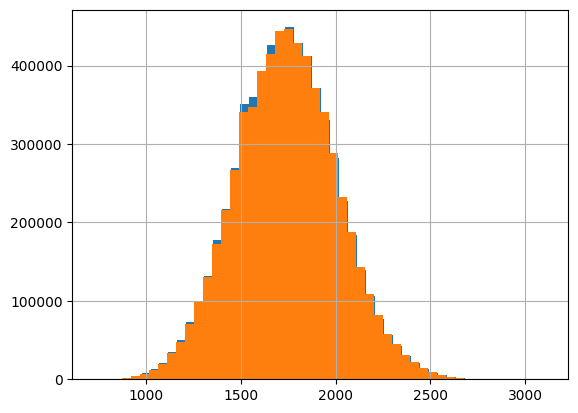

In [6]:
df[["WhiteElo", "BlackElo"]].describe()

df["WhiteElo"].hist(bins=50)
df["BlackElo"].hist(bins=50)


In [7]:
df[["WhiteElo", "BlackElo"]].describe()

,WhiteElo,BlackElo
count,6.256184e+06,6.256184e+06
mean,1.741945e+03,1.740390e+03
std,2.657171e+02,2.668938e+02
min,7.370000e+02,7.280000e+02
25%,1.559000e+03,1.557000e+03
50%,1.740000e+03,1.739000e+03
75%,1.919000e+03,1.919000e+03
max,3.110000e+03,3.108000e+03


In [8]:
df["TimeControl"].value_counts().head(20)


TimeControl
300+0     1075140
180+0      948615
60+0       912781
600+0      580351
30+0       307065
120+0      204505
180+2      163279
900+0      149067
300+5      105251
480+0       96941
300+8       96336
420+0       75072
240+0       70457
120+1       68661
300+2       63912
300+3       62821
1200+0      55508
60+1        53376
60+2        47350
300+4       45054
Name: count, dtype: int64

In [9]:
#Longueur des parties en nombre de coups
df["AN"].str.count(r"\.")\
    .describe()


count    6.256184e+06
mean     5.324866e+01
std      5.703862e+01
min      1.000000e+00
25%      2.500000e+01
50%      3.500000e+01
75%      5.200000e+01
max      6.620000e+02
Name: AN, dtype: float64

In [10]:
#Créer une colonne nb_coups + base nettoyée

# 1) nombre de coups (approx) = nombre de "."
df["nb_coups"] = df["AN"].str.count(r"\.")

# 2) base time (en secondes) depuis TimeControl "300+0" -> 300
df["base_seconds"] = pd.to_numeric(df["TimeControl"].str.split("+").str[0], errors="coerce")

# sanity check
print(df[["nb_coups", "base_seconds"]].describe())
print("TimeControl NaN:", df["base_seconds"].isna().mean())


           nb_coups  base_seconds
count  6.256184e+06  6.233244e+06
mean   5.324866e+01  3.137729e+02
std    5.703862e+01  4.036416e+02
min    1.000000e+00  0.000000e+00
25%    2.500000e+01  1.200000e+02
50%    3.500000e+01  2.400000e+02
75%    5.200000e+01  3.000000e+02
max    6.620000e+02  1.080000e+04
TimeControl NaN: 0.0036667719491626206


In [11]:
# --- FILTRAGE PRINCIPAL ---

allowed_termination = {"Normal", "Time forfeit"}

mask = (
    (df["WhiteElo"].between(1500, 2000)) &
    (df["BlackElo"].between(1500, 2000)) &
    (df["Termination"].isin(allowed_termination)) &
    (df["Result"] != "*") &
    (df["base_seconds"].notna()) &
    (df["base_seconds"] >= 180) &
    (df["nb_coups"] >= 20)
)

df_filt = df.loc[mask].copy()

print("After filtering:", df_filt.shape)
print("Proportion kept:", len(df_filt) / len(df))


After filtering: (1999640, 17)
Proportion kept: 0.3196261491030315


In [12]:
# Sous-échantillonnage reproductible
df_sample = df_filt.sample(n=300_000, random_state=42)

print(df_sample.shape)


(300000, 17)


In [15]:
from pathlib import Path

PROJECT_ROOT = Path("..")

out_dir = PROJECT_ROOT / "data" / "processed"
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "chess_filtered_sample_300k.csv"

df_sample.to_csv(out_path, index=False)

print("Saved to:", out_path.resolve())


Saved to: C:\Users\Victor\Documents\M2 MBFA\Machine Learning\Projet_chess\data\processed\chess_filtered_sample_300k.csv


In [17]:
import pandas as pd

from pathlib import Path

PROJECT_ROOT = Path("..")

df_pos = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "chess_positions_c20.csv")


print(df_pos.shape)
print(df_pos.head(3))
print(df_pos["label"].value_counts(normalize=True))


(258645, 6)
   label  WhiteElo  BlackElo  base_seconds Termination  \
0      0      1644      1612           600      Normal   
1      2      1856      1772           180      Normal   
2      0      1721      1831           600      Normal   

                                             fen_c20  
0  2rq1rk1/3bbppp/3p2n1/1p1Pp3/pP2P3/2PQBNPP/B3NK...  
1  2k4r/ppqbb3/n1pp4/3Ppp1p/2P3pP/PPN1P1P1/5PB1/R...  
2  r4rk1/p4p1p/2Q3p1/8/4Pp2/1P2qP2/P3N1PP/b4R1K w...  
label
2    0.484823
0    0.464451
1    0.050726
Name: proportion, dtype: float64
